In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Structures")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Structures]


## 웹 검색 모듈 추가

03.LangGraph-Add-Groundedness-Check.ipynb 과 04.LangGraph-Add-WebSearch.ipynb 에서 이어서 진행합니다.  
  
문서 검색을 하기 전에 사용자의 질의를 재구성 하는 노드를 추가합니다.
  
##### 그래프 흐름

![langgraph_structures_add_query_rewrite.png](./assets/langgraph_structures_add_query_rewrite.png)

In [3]:
from rag.pdf import PDFRetrievalChain

from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# PDF 문서 검색 체인 생성, 체인 안에는 llm 이 포함되어 있음
pdf = PDFRetrievalChain(
    source_uri=["./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf"]
).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [4]:
# 그래프 상태 정의
class GraphState(TypedDict):
    question: Annotated[List[str], add_messages]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적)
    relevance: Annotated[str, "Relevance"]  # 관련성 체크

In [5]:
from langchain_openai import ChatOpenAI
from evaluators import GroundednessChecker
from langchain_print import messages_to_history
from rag.utils import format_docs
from tools_tavily import TavilySearch


# 노드 정의
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs_formatted = format_docs(retrieved_docs)

    return GraphState(context=retrieved_docs_formatted)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 마지막 질문 추출
    latest_question = state["question"][-1].content
    # 검색된 문서 추출
    context = state["context"]

    # 답변 생성
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관령성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # 검색된 문서와 관련성 평가 생성
    # question-retrieval - 모드는 검색된 문서가 질문과 관련이 있는지 평가
    checker = GroundednessChecker(llm=llm, target="question-retrieval")
    evaluator = checker.create()

    response = evaluator.invoke(
        {
            "question": state["question"][-1].content,  # 질문
            "context": state["context"],  # 문서의 검색 결과
        }
    )

    return GraphState(relevance=response.score)


# 관련성 체크 결과에 따라 체크 결과를 반환하는 노드
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"


# 웹 검색 노드
def web_search(state: GraphState) -> GraphState:
    tavily_tool = TavilySearch()
    search_query = state["question"][-1].content

    search_results = tavily_tool.invoke(
        input=search_query,  # 검색 쿼리
        topic="general",  # 주제
        max_results=5,  # 최대 검색 결과 수
        format_output=True,  # 결과 포매팅
    )

    return GraphState(context=search_results)

rewrite 노드를 추가합니다.

In [6]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite 프롬프트 생성
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["question"],
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

In [7]:
# 질문 재작성
question = "AI 투자 금액"

question_rewriter.invoke({"question": question})

'"AI에 대한 투자 금액은 얼마인가요?"'

In [8]:
# 노드 생성
def question_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    rewritten_question = question_rewriter.invoke({"question": latest_question})
    return GraphState(question=rewritten_question)

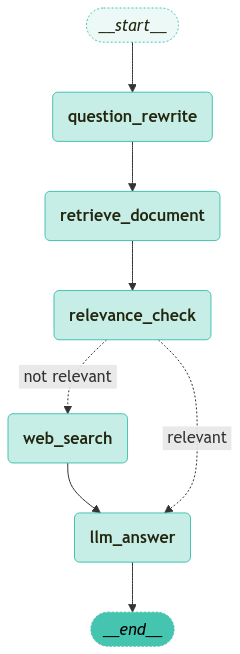

In [9]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from graphs import visualize_graph

# 그래프 정의 및 엣지 설정
workflow = StateGraph(GraphState)

# 노드 및 엣지 설정
workflow.add_node("retrieve_document", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)

# Query Rewrite 노드 추가
workflow.add_node("question_rewrite", question_rewrite)

workflow.add_edge("question_rewrite", "retrieve_document")
workflow.add_edge("retrieve_document", "relevance_check")

# 조건부 노드 추가
workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {"relevant": "llm_answer", "not relevant": "web_search"},
)

workflow.add_edge("web_search", "llm_answer")
workflow.add_edge("llm_answer", END)

# 시작 노드 설정
workflow.set_entry_point("question_rewrite")

# 메모리 설정
memory = MemorySaver()

# 그래프 생성
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

In [10]:
from langchain_core.runnables import RunnableConfig
from langchain_print import stream_graph, invoke_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="AI 위험 유형 및 사례 분석에 대해 설명해주세요.")

invoke_graph(app, inputs, config)


🔄 Node: question_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
AI의 위험 유형과 사례를 분석해 주실 수 있나요?

🔄 Node: retrieve_document 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>Ⅲ. AI 위험별 사례 분석 ·······························································11
3.1 악의적 사용 위험 ·····························································11
3.2 오작동 위험 ······································································14</content><source>./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf</source><page>3</page></document>
<document><content>관련된 개념을 정리하고, 최근 수행된 연구들이 제시하고 있는 AI 위험 유형 및 요인을 정리하여, 사례와
함께 분석함으로써 앞으로의 AI 위험 대응에 관한 정책적 시사점을 제공하고자 한다.</content><source>./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf</source><page>4</page></document>
<document><content>위해, 기존 AI 위험 프레임워크들에 대한 검토를 수행하고 개별적인 AI 위험을 추출
∙ 총 43개의 논문 및 보고서 분석을 기반으로, AI 위험 요인들에 대해 인과 분류*와 도메인별 분류를 제시
*인과 분류에서는 AI 위험의 주체(인간, AI), 의도(의도적, 비의도적), 발생 시기에 따른 분류(배포 전, 배포 후) 수행
∙ 추출된 700개 이상의 위험들은 AI 위

In [11]:
stream_graph(app, inputs, config, ["query_rewrite", "llm_answer"])


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
AI의 위험 유형은 크게 두 가지로 나눌 수 있습니다: 

1. **악의적 사용 위험**: 
   - 가짜 콘텐츠 생성
   - 허위 정보 생성
   - 사용자 설득 및 여론 조작
   - 사이버 공격 및 보안 위협

2. **오작동 위험**: 
   - 시스템의 자동적인 불안전 작동

**Source**
- ./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (페이지 11, 14)

In [12]:
# 최종 출력 확인
outputs = app.get_state(config).values

print(f'Original Question: {outputs["question"][0].content}')
print(f'Rewritten Question: {outputs["question"][-1].content}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Original Question: AI 위험 유형 및 사례 분석에 대해 설명해주세요.
Rewritten Question: AI의 위험 유형과 사례를 분석해 주실 수 있나요?
Answer:
AI의 위험 유형은 크게 두 가지로 나눌 수 있습니다: 

1. **악의적 사용 위험**: 
   - 가짜 콘텐츠 생성
   - 허위 정보 생성
   - 사용자 설득 및 여론 조작
   - 사이버 공격 및 보안 위협

2. **오작동 위험**: 
   - 시스템의 자동적인 불안전 작동

**Source**
- ./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (페이지 11, 14)
